# Workbook for testing ML on 3 years of ozone,aq data and met data from Rathmines

## Importing Modules and Dataset

In [199]:


import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import FactorAnalysis
# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [200]:
df = pd.read_csv('./RathminesDataForIngestion2003-2005withdates.csv',thousands=',', low_memory=False)
# You can also open with Excel and take a look at it.

In [201]:
# Print first 5 rows of the dataframe
df.head(4)
df.dtypes

Date         object
Hour          int64
Ozone       float64
NOx         float64
NO          float64
NO2         float64
SO2         float64
indrain       int64
rain        float64
indtemp       int64
temp        float64
indwet        int64
wetb        float64
dewpt       float64
vappr       float64
rhum          int64
msl         float64
indwdsp       int64
wdsp          int64
indwddir      int64
wddir         int64
ww            int64
w             int64
sun         float64
vis           int64
clht          int64
clamt         int64
dtype: object

In [202]:
# Print last 5 rows of the dataframe
df.head(5)

,Date,Hour,Ozone,NOx,NO,NO2,SO2,indrain,rain,indtemp,...,indwdsp,wdsp,indwddir,wddir,ww,w,sun,vis,clht,clamt
0,01/01/2003,0,38.0,5.5,0.0,5.5,NaN,0,0.2,0,...,2,21,2,140,58,65,0.0,6000,5,8
1,01/01/2003,1,42.0,6.0,0.5,5.5,NaN,0,0.5,0,...,2,21,2,130,58,65,0.0,4500,3,8
2,01/01/2003,2,50.0,5.5,0.5,5.0,NaN,0,1.8,0,...,2,19,2,130,58,65,0.0,8000,7,8
3,01/01/2003,3,50.0,7.0,0.0,7.0,NaN,0,5.4,0,...,2,16,2,140,63,65,0.0,8000,7,8
4,01/01/2003,4,40.0,11.0,0.0,11.0,NaN,0,0.9,0,...,2,12,2,140,60,62,0.0,9000,8,8


# Lets have a look at the met data indicators

In [203]:
df['indrain'].value_counts()

0    20142
2     3678
3     2482
1        2
Name: indrain, dtype: int64

In [204]:
df['indwet'].value_counts()

0    25632
1      662
5       10
Name: indwet, dtype: int64

In [205]:
df['indtemp'].value_counts()

0    25833
1      471
Name: indtemp, dtype: int64

In [206]:
df['indwddir'].value_counts()

2    26299
4        5
Name: indwddir, dtype: int64

In [207]:
df['indwdsp'].value_counts()

2    26303
4        1
Name: indwdsp, dtype: int64

In [208]:
# Print statistical summary for all numerical attributes
df.describe()

,Hour,Ozone,NOx,NO,NO2,SO2,indrain,rain,indtemp,temp,...,indwdsp,wdsp,indwddir,wddir,ww,w,sun,vis,clht,clamt
count,26304.000000,25833.000000,25326.000000,25326.000000,25326.000000,24461.000000,26304.000000,26304.000000,26304.000000,26304.000000,...,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000
mean,11.500000,43.760020,19.395412,7.510377,11.885102,5.889248,0.562804,0.077524,0.017906,9.982238,...,2.000076,10.695674,2.000380,211.487987,14.495894,29.640055,0.173023,29057.028779,296.807216,5.577175
std,6.922318,21.562965,29.336079,22.969049,9.227101,5.418500,1.044940,0.385878,0.132612,4.983192,...,0.012332,5.432511,0.027572,83.343652,21.915629,27.138356,0.332289,15863.199487,406.977548,2.299177
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.400000,...,2.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,5.000000,1.000000,0.000000
25%,5.750000,29.000000,6.600000,0.800000,5.300000,2.700000,0.000000,0.000000,0.000000,6.500000,...,2.000000,7.000000,2.000000,140.000000,2.000000,11.000000,0.000000,18000.000000,27.000000,4.000000
50%,11.500000,46.200000,11.800000,2.300000,9.300000,4.000000,0.000000,0.000000,0.000000,10.000000,...,2.000000,10.000000,2.000000,230.000000,2.000000,11.000000,0.000000,30000.000000,50.000000,7.000000
75%,17.250000,59.000000,20.600000,5.000000,16.000000,7.200000,0.000000,0.000000,0.000000,13.600000,...,2.000000,14.000000,2.000000,270.000000,21.000000,62.000000,0.100000,40000.000000,250.000000,7.000000
max,23.000000,142.600000,598.100000,523.300000,74.800000,81.100000,3.000000,12.000000,1.000000,25.500000,...,4.000000,42.000000,4.000000,360.000000,96.000000,98.000000,1.000000,75000.000000,999.000000,8.000000


# Just to keep things simple, I get rid of the follwing colums

In [124]:
df.drop('Date', axis=1, inplace=True)

In [125]:
df.drop('indrain', axis=1, inplace=True)

In [126]:
df.drop('indtemp', axis=1, inplace=True)

In [127]:
df.drop('indwddir', axis=1, inplace=True)

In [128]:
df.drop('msl', axis=1, inplace=True)

In [129]:
df.drop('indwet', axis=1, inplace=True)

In [130]:
df.drop('indwdsp', axis=1, inplace=True)

In [131]:
df.drop('ww', axis=1, inplace=True)

In [132]:
df.drop('w', axis=1, inplace=True)

In [133]:
df.drop('sun', axis=1, inplace=True)

In [134]:
df.drop('vis', axis=1, inplace=True)

In [135]:
df.drop('clamt', axis=1, inplace=True)

In [136]:
df.drop('clht', axis=1, inplace=True)

In [137]:
df.drop('wetb', axis=1, inplace=True)

In [138]:
df.drop('dewpt', axis=1, inplace=True)

In [139]:
df.drop('rain', axis=1, inplace=True)

In [140]:
df.drop('vappr', axis=1, inplace=True)

# QUICK LOOK AT THE DATA TO MAKE SURE ALL OK

# HEATMAP

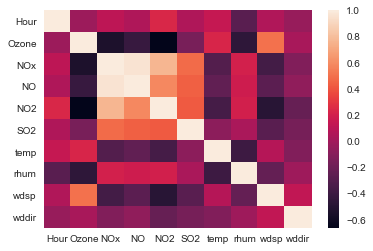

In [141]:
#correlation matrix
sns.heatmap(df.corr());

# XY Plots

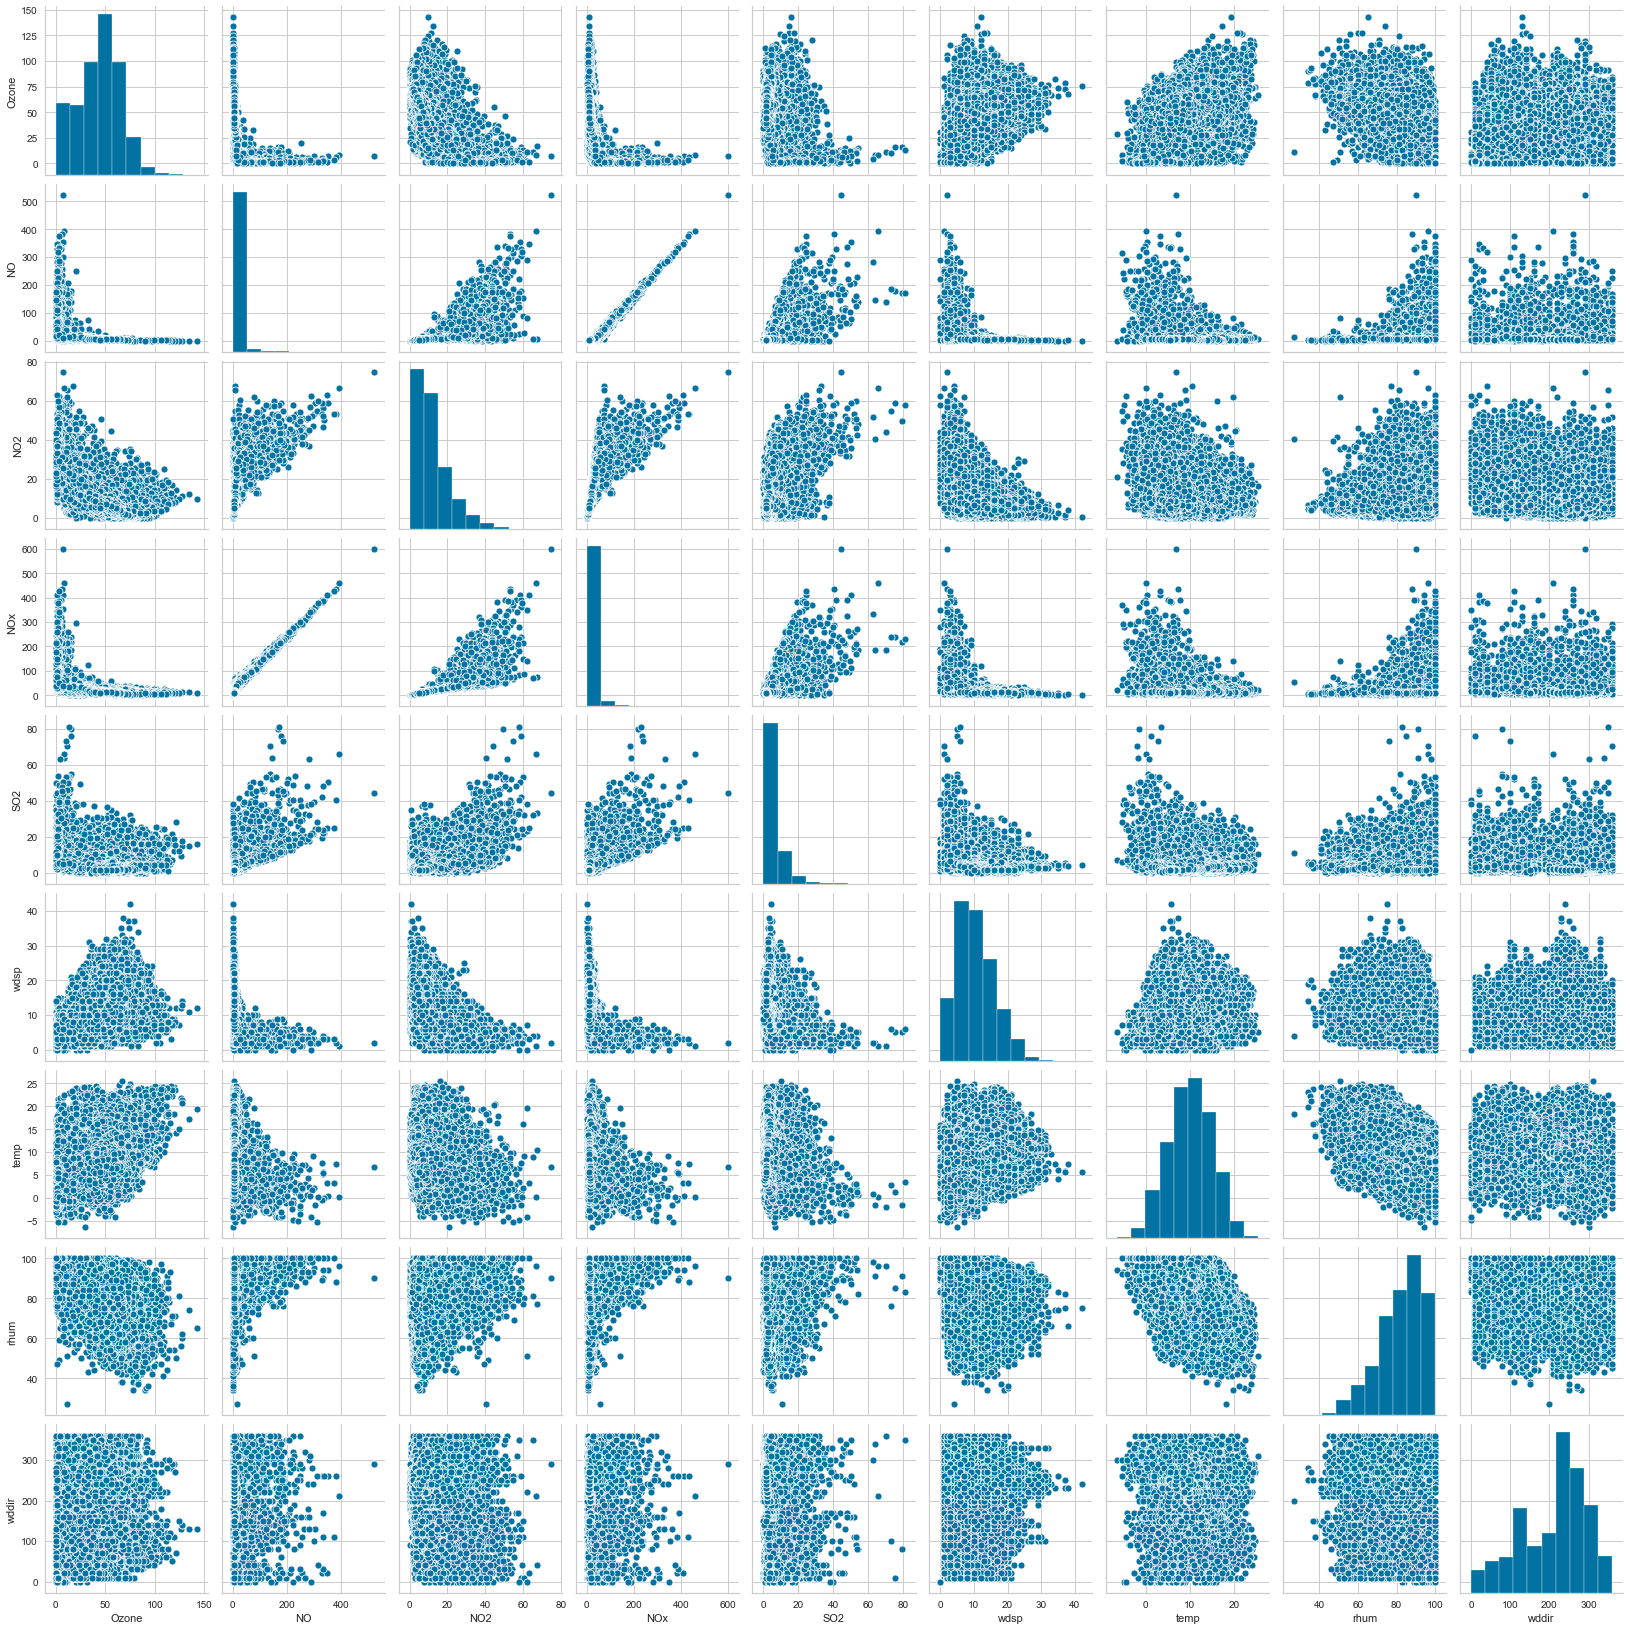

In [142]:
# note that by applying the method dropna() we drop all rows with missing values 
sns.pairplot(data=df[['Ozone','NO','NO2','NOx','SO2','wdsp','temp','rhum','wddir']].dropna())
plt.show()

# Box Plots

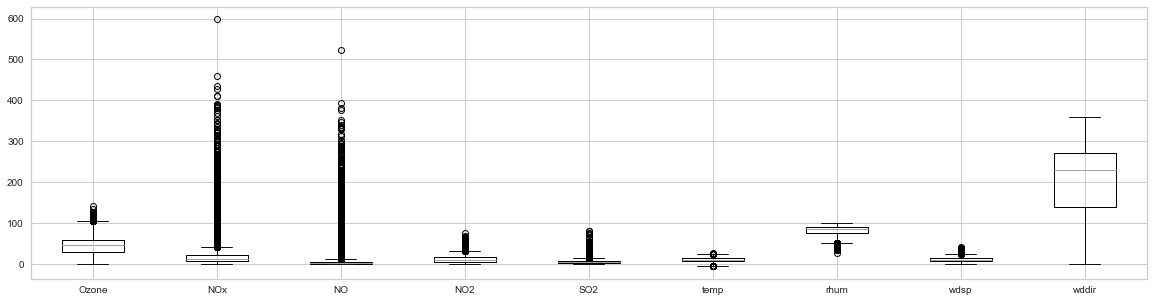

In [143]:
df.loc[:,'Ozone':'wddir'].boxplot(figsize=(20,5))
plt.show()

# Histograms

In [144]:
df.isna().sum()

Hour        0
Ozone     471
NOx       978
NO        978
NO2       978
SO2      1843
temp        0
rhum        0
wdsp        0
wddir       0
dtype: int64

# Dopping rows with nan's and missing data

In [145]:
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [146]:
df.isna().sum()

Hour     0
Ozone    0
NOx      0
NO       0
NO2      0
SO2      0
temp     0
rhum     0
wdsp     0
wddir    0
dtype: int64

In [147]:
# Print statistical summary for all numerical attributes
df.describe()

,Hour,Ozone,NOx,NO,NO2,SO2,temp,rhum,wdsp,wddir
count,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000
mean,11.500745,43.515056,19.493282,7.573070,11.920162,5.891751,10.129287,82.299936,10.578941,211.427356
std,6.938642,21.639781,29.490407,23.152477,9.216189,5.456712,4.938625,11.534247,5.377614,83.632538
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.400000,27.000000,0.000000,0.000000
25%,5.000000,28.800000,6.700000,0.900000,5.300000,2.700000,6.700000,75.000000,7.000000,140.000000
50%,11.000000,46.000000,11.900000,2.300000,9.300000,4.000000,10.100000,85.000000,10.000000,230.000000
75%,18.000000,58.600000,20.700000,5.100000,16.000000,7.200000,13.700000,91.000000,14.000000,270.000000
max,23.000000,142.600000,598.100000,523.300000,74.800000,81.100000,25.500000,100.000000,42.000000,360.000000


# Histograms 

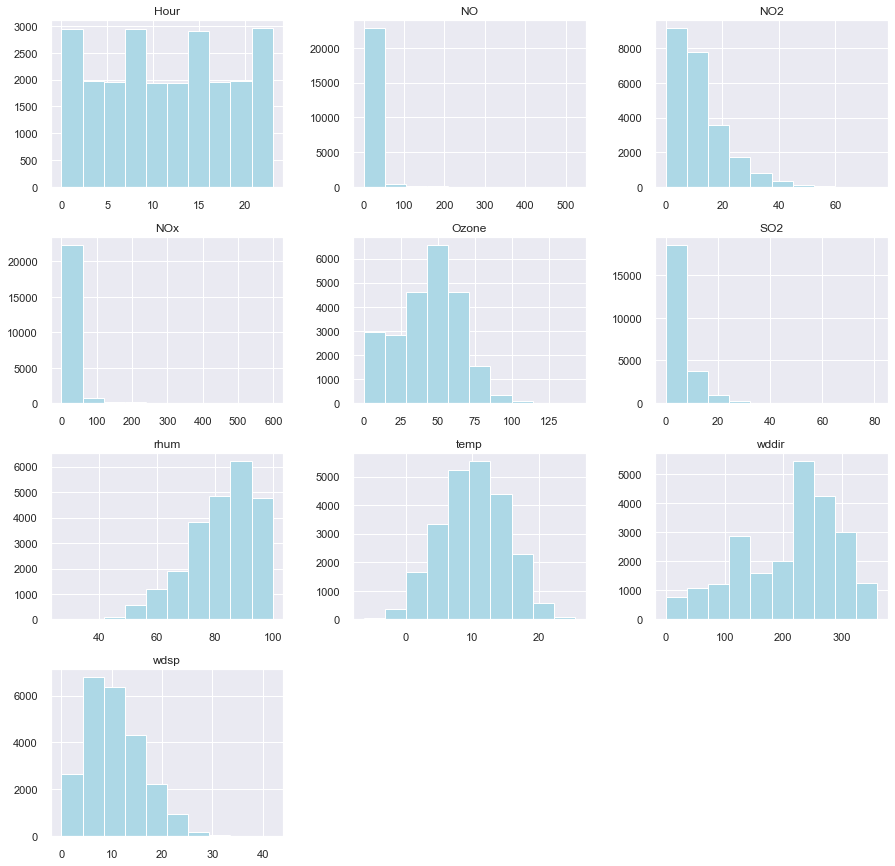

In [148]:
sns.set()
pd.DataFrame.hist(df, figsize = [15,15], color='lightblue')
plt.show()

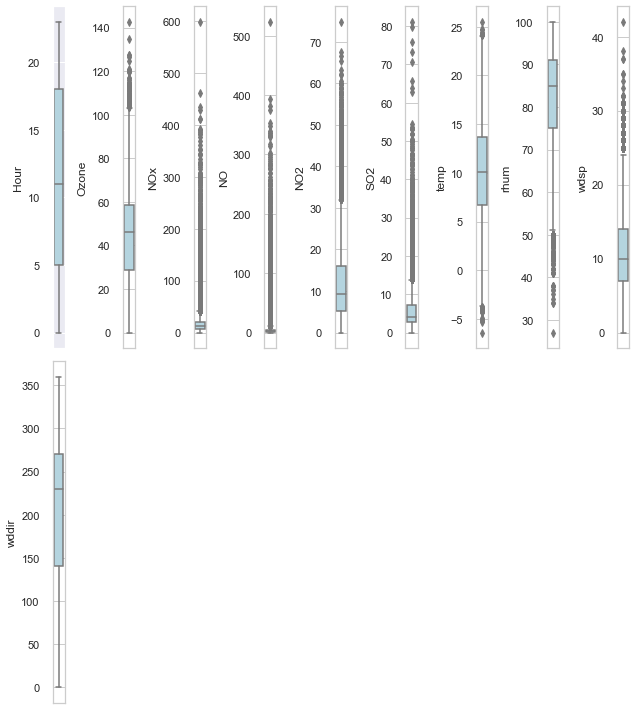

In [149]:

l = df.columns.values
number_of_columns=9
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]],color='lightblue',orient='v')
    plt.tight_layout()

# Distributions 

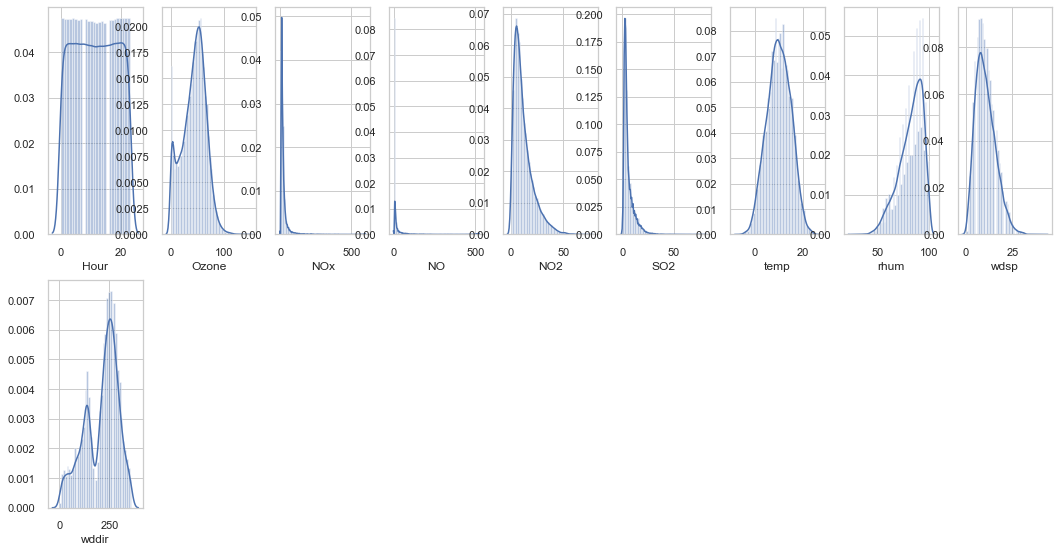

In [150]:

plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df[l[i]],kde=True)

In [151]:
# Print statistical summary for all numerical attributes
df.describe()

,Hour,Ozone,NOx,NO,NO2,SO2,temp,rhum,wdsp,wddir
count,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000
mean,11.500745,43.515056,19.493282,7.573070,11.920162,5.891751,10.129287,82.299936,10.578941,211.427356
std,6.938642,21.639781,29.490407,23.152477,9.216189,5.456712,4.938625,11.534247,5.377614,83.632538
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.400000,27.000000,0.000000,0.000000
25%,5.000000,28.800000,6.700000,0.900000,5.300000,2.700000,6.700000,75.000000,7.000000,140.000000
50%,11.000000,46.000000,11.900000,2.300000,9.300000,4.000000,10.100000,85.000000,10.000000,230.000000
75%,18.000000,58.600000,20.700000,5.100000,16.000000,7.200000,13.700000,91.000000,14.000000,270.000000
max,23.000000,142.600000,598.100000,523.300000,74.800000,81.100000,25.500000,100.000000,42.000000,360.000000


# Adjustment of data to avoid zero's

In [152]:
# Print statistical summary for all numerical attributes
# Use a log transformation to decrease the impact of outliers
df['Ozone'] = df['Ozone']+1.00
df['NO'] = df['NO']+1.00
df['NO2'] = df['NO2']+1.00
df['wdsp'] = df['wdsp']+1.00
df['temp'] = df['temp']+7.50
df['NOx'] = df['NOx']+1.00
df['Hour'] = df['Hour']+1.00
df['wddir'] = df['wddir']/360 + 1.00
df['SO2'] = df['SO2']+1.00

In [153]:

df['rhum'] = df['rhum']


In [154]:
# Print statistical summary for all numerical attributes
df.describe()

,Hour,Ozone,NOx,NO,NO2,SO2,temp,rhum,wdsp,wddir
count,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000
mean,12.500745,44.515056,20.493282,8.573070,12.920162,6.891751,17.629287,82.299936,11.578941,1.587298
std,6.938642,21.639781,29.490407,23.152477,9.216189,5.456712,4.938625,11.534247,5.377614,0.232313
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.100000,27.000000,1.000000,1.000000
25%,6.000000,29.800000,7.700000,1.900000,6.300000,3.700000,14.200000,75.000000,8.000000,1.388889
50%,12.000000,47.000000,12.900000,3.300000,10.300000,5.000000,17.600000,85.000000,11.000000,1.638889
75%,19.000000,59.600000,21.700000,6.100000,17.000000,8.200000,21.200000,91.000000,15.000000,1.750000
max,24.000000,143.600000,599.100000,524.300000,75.800000,82.100000,33.000000,100.000000,43.000000,2.000000


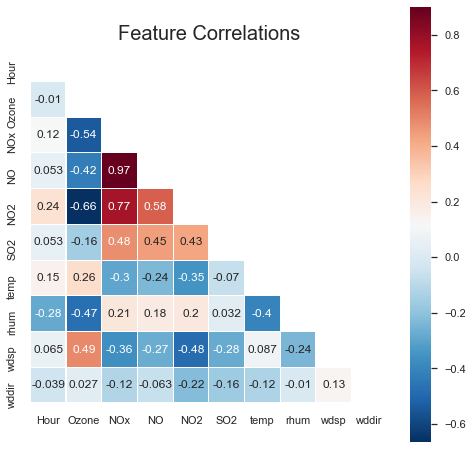

In [155]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (8,8))
sns.heatmap(df.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Feature Correlations", y = 1.03,fontsize = 20)
plt.show()

In [156]:
# Print first 5 rows of the dataframe
df.dtypes

Hour     float64
Ozone    float64
NOx      float64
NO       float64
NO2      float64
SO2      float64
temp     float64
rhum       int64
wdsp     float64
wddir    float64
dtype: object

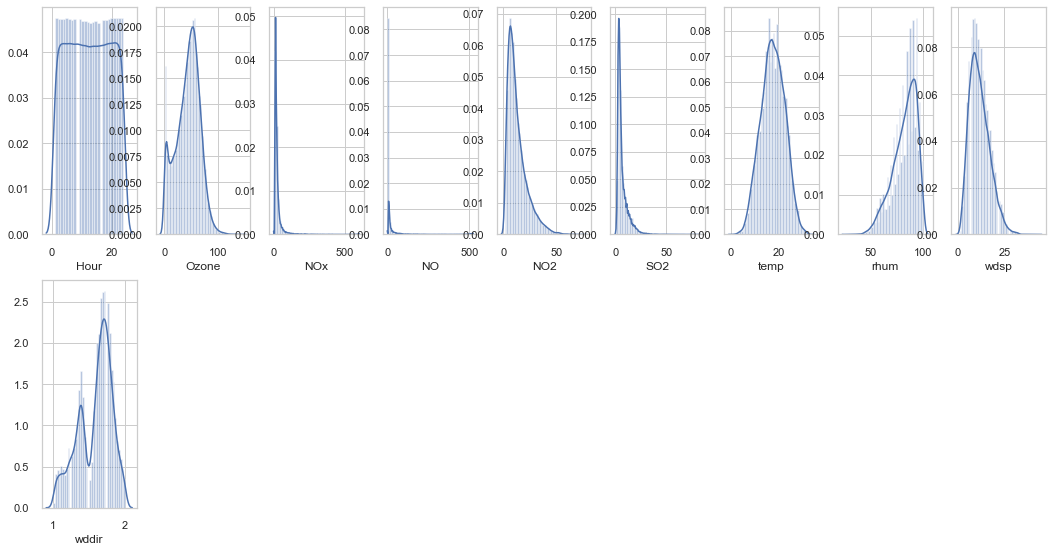

In [157]:

plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df[l[i]],kde=True)

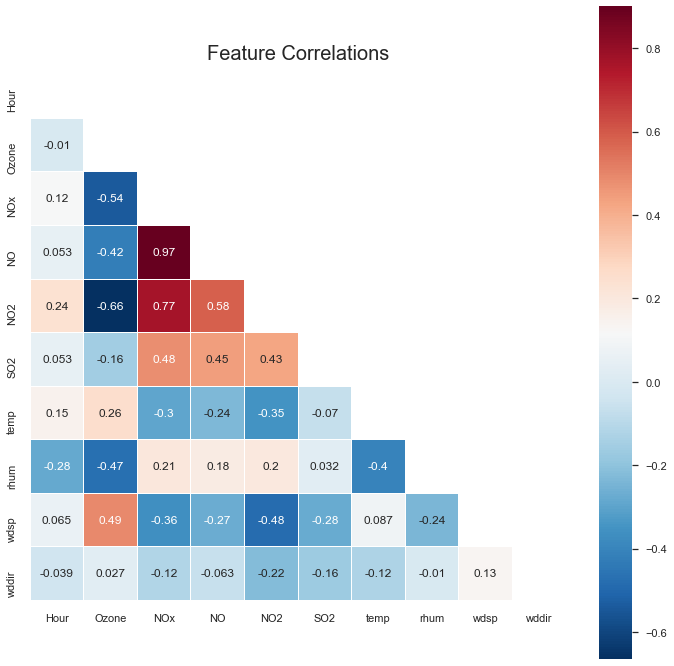

In [158]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.subplots(figsize = (12,12))
sns.heatmap(df.corr(), 
            annot=True,
            mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Feature Correlations", y = 1.03,fontsize = 20)
plt.show()

In [159]:
# Print statistical summary for all numerical attributes
df.describe()

,Hour,Ozone,NOx,NO,NO2,SO2,temp,rhum,wdsp,wddir
count,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000,23505.000000
mean,12.500745,44.515056,20.493282,8.573070,12.920162,6.891751,17.629287,82.299936,11.578941,1.587298
std,6.938642,21.639781,29.490407,23.152477,9.216189,5.456712,4.938625,11.534247,5.377614,0.232313
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.100000,27.000000,1.000000,1.000000
25%,6.000000,29.800000,7.700000,1.900000,6.300000,3.700000,14.200000,75.000000,8.000000,1.388889
50%,12.000000,47.000000,12.900000,3.300000,10.300000,5.000000,17.600000,85.000000,11.000000,1.638889
75%,19.000000,59.600000,21.700000,6.100000,17.000000,8.200000,21.200000,91.000000,15.000000,1.750000
max,24.000000,143.600000,599.100000,524.300000,75.800000,82.100000,33.000000,100.000000,43.000000,2.000000


## Data Preparation

In [160]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['Ozone']]

# define column groups with the same data preparation
names_outliers = ['NO2', 'NO','wdsp','temp','rhum','NOx','SO2']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [161]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [162]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [163]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()  
        ))
    ])
)

In [164]:
y = df['Ozone']
X = df.drop('Ozone', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True)

## Random Forest Regressor

In [165]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=100))])

In [166]:
N_FEATURES_OPTIONS = [7]
MAX_DEPTH_OPTIONS = [12]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FastICA( algorithm='deflation')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
]    

search = GridSearchCV(pipe, param_grid, cv=10, iid = False, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best CV score = 0.762:
Best parameters:  {'reduce_dim': TruncatedSVD(algorithm='arpack', n_components=7, n_iter=5, random_state=None,
             tol=0.0), 'reduce_dim__n_components': 7}


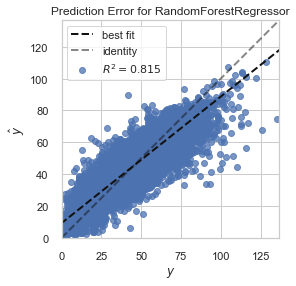

In [167]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError


model = RandomForestRegressor()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## Linear Regression

In [168]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [169]:
N_FEATURES_OPTIONS = [11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [FastICA( algorithm='deflation')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.681:
Best parameters:  {'reduce_dim': PCA(copy=True, iterated_power=7, n_components=11, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 11, 'regresson__normalize': False}


C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


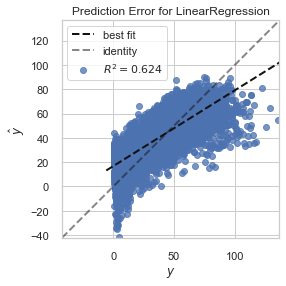

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError


model = LinearRegression()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## AdaBoost Regressor

In [171]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regression', AdaBoostRegressor())])

In [172]:
N_FEATURES_OPTIONS = [15]
NORMALIZE_OPTIONS = [False, True]
AB_LEARNING_RATES = [0.2]
AB_LOSS = ['linear', 'square', 'exponential']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regression__learning_rate': AB_LEARNING_RATES,
        'regression__loss': AB_LOSS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regression__learning_rate': AB_LEARNING_RATES,
        'regression__loss': AB_LOSS
    },
    {
        'reduce_dim': [FastICA( algorithm='deflation')],
    },
    {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    }   
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
AB_best_params = search.best_params_
AB_best_model = search.best_estimator_

C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best CV score = 0.655:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                  gamma='auto', kernel='linear', max_iter=-1, shrinking=True,
                  tol=0.001, verbose=False),
    n_features_to_select=15, step=1, verbose=0), 'reduce_dim__n_features_to_select': 15, 'regression__learning_rate': 0.2, 'regression__loss': 'exponential'}


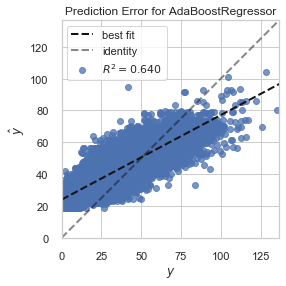

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError


model = AdaBoostRegressor()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## Gradient Booster

In [174]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', GradientBoostingRegressor())])

In [175]:
N_FEATURES_OPTIONS = [12]
MAX_DEPTH_OPTIONS = [8]

param_grid = [
     {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [FactorAnalysis(svd_method='randomized'), FactorAnalysis(svd_method='lapack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }

   
]
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
GB_best_params = search.best_params_
GB_best_model = search.best_estimator_

C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best CV score = 0.759:
Best parameters:  {'reduce_dim': PCA(copy=True, iterated_power=7, n_components=12, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 12, 'regresson__max_depth': 8}


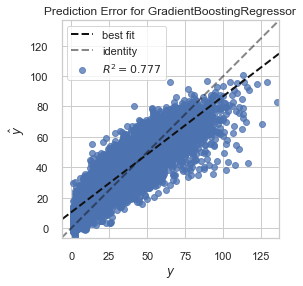

In [176]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError


model = GradientBoostingRegressor()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## SVR

In [177]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', SVR ())])

In [178]:
KERNEL = ['linear']
C = [300]
GAMMA = ['auto']
N_FEATURES_OPTIONS = [9]


param_grid = [
     {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [FactorAnalysis(svd_method='randomized'), FactorAnalysis(svd_method='lapack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    }
]
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_


C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best CV score = 0.736:
Best parameters:  {'reduce_dim': TruncatedSVD(algorithm='arpack', n_components=9, n_iter=5, random_state=None,
             tol=0.0), 'reduce_dim__n_components': 9}


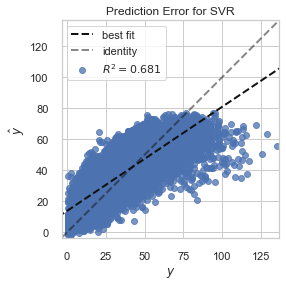

In [179]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError


model = SVR()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## ANN

In [180]:
from sklearn.neural_network import MLPRegressor

In [181]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', MLPRegressor ())])

In [182]:
ALPHA = [0.001, 0.01, 0.1, 1, 10, 100], 
HIDDEN_LAYER_SIZES = [(6),(11,11),(7,7,7)] 
SOLVER = ['adam'] 
ACTIVATION = ['relu','tanh','identity','logistic'] 
LEARNING_RATE = ['constant','invscaling','adaptive']
N_FEATURES_OPTIONS = [10]
MAX_ITER = [500]

param_grid = [
     {
        'reduce_dim': [TruncatedSVD(algorithm='randomized'), TruncatedSVD(algorithm='arpack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [FactorAnalysis(svd_method='randomized'), FactorAnalysis(svd_method='lapack')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },

]
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best CV score = 0.755:
Best parameters:  {'reduce_dim': TruncatedSVD(algorithm='arpack', n_components=10, n_iter=5, random_state=None,
             tol=0.0), 'reduce_dim__n_components': 10}


C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


C:\Users\0110900s\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


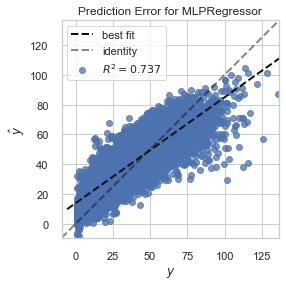

In [183]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from yellowbrick.regressor import PredictionError


model = MLPRegressor()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

## Plotting data

In [184]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [185]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
    _meae = median_absolute_error(y_test, _predicted_values)
          
    return _mse, _mae, _r2, _meae

In [193]:
RF_mse, RF_mae, RF_r2, RF_meae = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2, LR_meae = evaluate_model(X_test, y_test, LR_best_model)
AB_mse, AB_mae, AB_r2, AB_meae = evaluate_model(X_test, y_test, AB_best_model)
GB_mse, GB_mae, GB_r2, GB_meae = evaluate_model(X_test, y_test, GB_best_model)
SVR_mse, SVR_mae, SVR_r2, SVR_meae = evaluate_model(X_test, y_test, SVR_best_model)
MLP_mse, MLP_mae, MLP_r2, MLP_meae = evaluate_model(X_test, y_test, MLP_best_model)

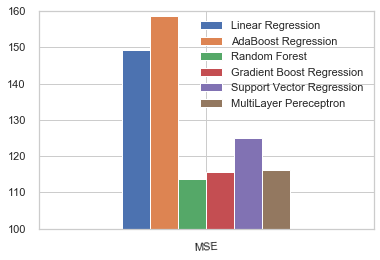

In [197]:
AB_metrics = np.array([AB_mse])
RF_metrics = np.array([RF_mse])
LR_metrics = np.array([LR_mse])
GB_metrics = np.array([GB_mse])
SVR_metrics = np.array([SVR_mse])
MLP_metrics = np.array([MLP_mse])
index = ['MSE']
df_metrics = pd.DataFrame({'Linear Regression': LR_metrics,'AdaBoost Regression': AB_metrics,'Random Forest': RF_metrics, 'Linear Regression': LR_metrics, 'Gradient Boost Regression': GB_metrics, 'Support Vector Regression':SVR_metrics, 'MultiLayer Pereceptron':MLP_metrics}, index=index)
df_metrics.plot.bar(rot=3);plt.ylim((100,160))
plt.legend(loc="upper right")
plt.show()

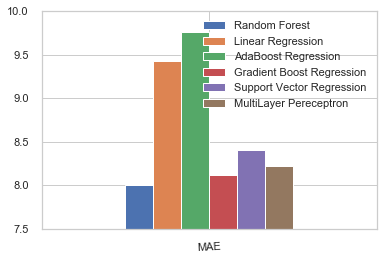

In [188]:
AB_metrics = np.array([AB_mae])
RF_metrics = np.array([RF_mae])
LR_metrics = np.array([LR_mae])
GB_metrics = np.array([GB_mae])
SVR_metrics = np.array([SVR_mae])
MLP_metrics = np.array([MLP_mae])
index = ['MAE']
df_metrics = pd.DataFrame({'Random Forest': RF_metrics, 'Linear Regression': LR_metrics, 'AdaBoost Regression': AB_metrics,'Gradient Boost Regression': GB_metrics,'Support Vector Regression':SVR_metrics,'MultiLayer Pereceptron':MLP_metrics }, index=index)
df_metrics.plot.bar(rot=3);plt.ylim((7.5,10.0))
plt.legend(loc="upper right")
plt.show()

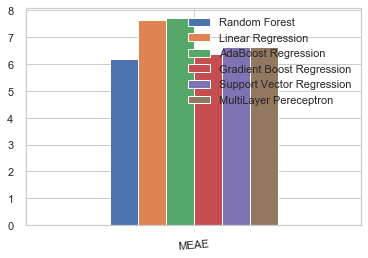

In [189]:
AB_metrics = np.array([AB_meae])
RF_metrics = np.array([RF_meae])
LR_metrics = np.array([LR_meae])
GB_metrics = np.array([GB_meae])
SVR_metrics = np.array([SVR_meae])
MLP_metrics = np.array([MLP_meae])
index = ['MEAE']
df_metrics = pd.DataFrame({'Random Forest': RF_metrics, 'Linear Regression': LR_metrics, 'AdaBoost Regression': AB_metrics,'Gradient Boost Regression': GB_metrics,'Support Vector Regression':SVR_metrics, 'MultiLayer Pereceptron':MLP_metrics}, index=index)
df_metrics.plot.bar(rot=5)
plt.legend(loc="upper right")
plt.show()

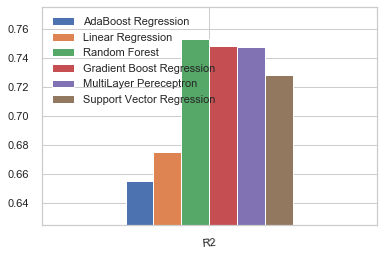

In [190]:
AB_metrics = np.array([AB_r2])
RF_metrics = np.array([RF_r2])
LR_metrics = np.array([LR_r2])
GB_metrics = np.array([GB_r2])
SVR_metrics = np.array([SVR_r2])
MLP_metrics = np.array([MLP_r2])

index = ['R2']
df_metrics = pd.DataFrame({'AdaBoost Regression': AB_metrics,'Linear Regression': LR_metrics, 'Random Forest': RF_metrics, 'Gradient Boost Regression': GB_metrics,  'MultiLayer Pereceptron':MLP_metrics,'Support Vector Regression':SVR_metrics}, index=index)
df_metrics.plot.bar(rot=5);plt.ylim((0.625,0.775)) 
plt.legend(loc="upper left")
plt.show()

## Station Name: DUBLIN AIRPORT
### Station Height: 71 M 
### Latitude:53.428  ,Longitude: -6.241


###### date:  -  Date and Time (utc)
###### rain:  -  Precipitation Amount (mm)	  
###### temp:  -  Air Temperature (C)	
###### wetb:  -  Wet Bulb Temperature (C)
###### dewpt: -  Dew Point Temperature (C)             
###### rhum:  -  Relative Humidity (%)
###### vappr: -  Vapour Pressure (hPa)	 
###### msl:   -  Mean Sea Level Pressure (hPa)
###### wdsp:  -  Mean Wind Speed (knot)
###### wddir: -  Predominant Wind Direction (degree)
###### ww:    -  Synop code for Present Weather
###### w:     -  Synop code for Past Weather
###### sun:   -  Sunshine duration (hours)
###### vis:   -  Visibility (m)
###### clht:  -  Cloud height (100's of ft) - 999 if none 
###### clamt: -  Cloud amount
###### ind:   -  Indicator

## Indicators (i)	    Description  - Decode                                                        

irain    Rainfall Indicators:		
                        0. satisfactory. 
	                    1. deposition. 
				        2. trace or sum of precipition. 
				        3. trace or sum of deposition. 
						4. estimate precipitation. 
				      	5 estimate deposition. 
						6. estimate trace of precipitation.

itemp		Temperature Indicators: 	
                        0. positive. 
						1. negative. 
						2. positive estimated. 	
						3. negative estimated. 
						4. not available. 

iwb  		Wet Bulb Indicators:    	
                        0:positive. 
						1. negative. 
						2. positive estimated. 
						3. negative estimated. 
				        4. not available. 
						5. frozen negative.

iwdsp		Wind Speed Indicators:		
                        2. Over 60 minutes. 
						4. Over 60 minutes and defective
						6 Over 60 minutes and partially defective. 
						7. n/a

iwddir		Wind Direction Indicators:  	
                        2. Over 60 minutes. 
						4. Over 60 minutes and defective
						6 Over 60 minutes and partially defective. 
						7. n/a

























# GRADIENT BOOSTING

In [74]:

# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     GB_best_params.get('reduce_dim'),
                     GradientBoostingRegressor(n_estimators=10, **transform(GB_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [75]:
import sys
filename = 'final_model_GB.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [76]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.6815657587530284


# Linear Regression

In [295]:

# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     LR_best_params.get('reduce_dim'),
                     LinearRegression(**transform(LR_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [296]:
import sys
filename = 'final_model_LR.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [297]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.6789667738611674


# Random Forest

In [298]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(**transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [299]:
import sys
filename = 'final_model_RF.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [300]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9683741372910405


# AdaBoostRegressor

In [301]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     AB_best_params.get('reduce_dim'),
                     AdaBoostRegressor(**transform(AB_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [302]:
import sys
filename = 'final_model_AB.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [303]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.6275625651105141


# SVR

In [304]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     SVR_best_params.get('reduce_dim'),
                     SVR(**transform(SVR_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [305]:
import sys
filename = 'final_model_SVR.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [306]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.7470870385361161
